## TauRunner

Welcome to the TauRunner tutorial! This software is capable of simulating neutrinos (and anti-neutrinos) of all flavors, accounting for tau regeneration and losses in the nutau channel. The output is a set of particle energies, number of interactions, angle, and particle type.

The user has the option to propagate:
1. monochromatic fluxes
2. power-law fluxes
3. Any provided arbitrary flux by means of sampling from a cdf. 

All of these can be propagated through either:
1. a fixed angle
2. a range of angles
3. uniformly sampled angles in the sky. 

In terms of astrophysical bodies, we provide implementations for the Earth and Sun with capabilities of adding additional layers and changing the detector depth. In addition, we will demonstrate how to define any astrophysical object, or a slab of constant density to propagate through. All of these capabilities will be shown in the following examples. Happy running!

In [1]:
from taurunner.main import run_MC
from taurunner.cross_sections import CrossSections
from taurunner.body import Body
from taurunner.body.earth import construct_earth

from taurunner.utils import make_initial_e
from taurunner.utils import make_initial_thetas
from taurunner.utils import make_propagator
from taurunner.utils.make_tracks import make_tracks

import proposal as pp
import numpy as np

## Example 1: Monochromatic flux through single angle in Earth ##

The main function that runs the monte carlo is called `run_MC` and required a few arguments, which we show you how to create below
* `energies`: An array of initial particle energies in eV
* `thetas`: A corresponding array of initial nadir angles in radians
* `body`: The body which we are propagating through (Earth, Sun, custom, etc.)
* `xs`: a CrossSections object which is based on a certain cross section model
* `tracks`: dictionary whose keys are angles and whose values are taurunner Track objects
* `propagator`: PROPOSAL propagator object for charged lepton propagation

In [2]:
nevents  = 10000                    # number of events to simulate
eini     = 1e19                     # intial energy in eV
theta    = np.radians(89.0)         # initial incidence angle (nadir) in radians
pid      = 16                       # particle id according to the PDG MC Encoding (nutau)
xs_model = 'CSMS'                   # neutrino cross section and tau loss model (CSMS or dipole)
                                   

Earth    = lumen_sit(layers=[(4., 1.0)])       # Make Earth object with 4km ice layer
xs       = CrossSections(xs_model)           # Make cross section object
energies = np.ones(nevents)*eini             # Make array of energies
thetas   = np.ones(nevents)*theta            # Make array of nadir angles in radians

tracks = make_tracks(thetas)
tau_prop = make_propagator(pid, Earth)
rand = np.random.RandomState(seed=7)

In [3]:
output = run_MC(energies, thetas, Earth, xs, tracks, tau_prop, rand)

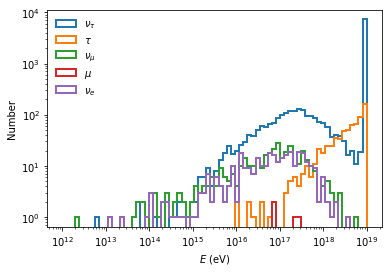

In [4]:
import matplotlib.pyplot as plt

pid_names = {
    11: 'r$e$', 
    12: r'$\nu_{e}$', 
    13: r'$\mu$', 
    14: r'$\nu_{\mu}$',
    15: r'$\tau$',
    16: r'$\nu_{\tau}$'
}

bins  = np.logspace(12, 19, 75)
zeros = output['Eout']==0.

for pid in reversed(range(12,17)):
    particle_msk = np.logical_and(np.abs(output['PDG_Encoding'])==pid, ~zeros)
    name = pid_names[pid]
    plt.hist(output['Eout'][particle_msk], bins=bins, label=name,
            lw=2., histtype='step')
    
plt.legend(frameon=False, loc=2)
plt.loglog()
plt.xlabel(r'$E$ (eV)')
plt.ylabel('Number')
plt.show()

## Example 2: Alternative spectral shapes over various angles

`taurunner` also provides helper functions to propagate other spectral shapes, such as power laws or pre-loaded models of cosmogenic neutrinos

In [5]:
nevents = 5000
energies = make_initial_e(nevents, -2., e_min=1e6, e_max=1e12, rand=rand) # spectral index -2. between 1e6 and 1e12 GeV
thetas   = make_initial_thetas(nevents, (0., 90.), rand=rand) # Sample uniform in solid angle over hemisphere
tracks   = make_tracks(thetas)

Here, we are choosing to propagate an $E^{-2}$ spectrum over an entire hemisphere. 
There are some additional keyword arguments that allow the user to turn off tau energy losses (which are less important for more steeply inclined angles) or ignore secondary particles

In [6]:
output = run_MC(energies, thetas, Earth, xs, tracks, tau_prop, rand, no_losses=True, no_secondaries=True)

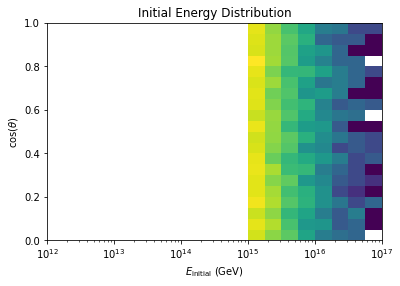

In [7]:
from matplotlib.colors import LogNorm

bins  = np.logspace(12, 19, 75)
zeros = output['Eout']==0.
nutau_msk = np.logical_and(np.abs(output['PDG_Encoding'])==16, ~zeros)
plt.hist2d(
    output['Eini'][nutau_msk], 
    np.cos(np.radians(output['Theta'][nutau_msk])), 
    bins=[np.logspace(12., 17., 21), 
          np.linspace(0., 1., 21)],
    norm=LogNorm()
)

plt.xscale('log')
plt.xlabel(r'$E_{\rm{initial}}$ (GeV)')
plt.ylabel(r'$\cos(\theta)$')
plt.title("Initial Energy Distribution")
plt.show()

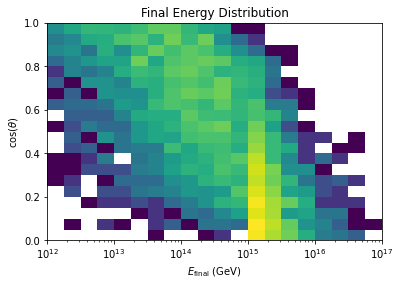

In [8]:
from matplotlib.colors import LogNorm

bins  = np.logspace(12, 19, 75)
zeros = output['Eout']==0.
nutau_msk = np.logical_and(np.abs(output['PDG_Encoding'])==16, ~zeros)
plt.hist2d(
    output['Eout'][nutau_msk], 
    np.cos(np.radians(output['Theta'][nutau_msk])), 
    bins=[np.logspace(12., 17., 21), 
          np.linspace(0., 1., 21)],
    norm=LogNorm()
)

plt.xscale('log')
plt.xlabel(r'$E_{\rm{final}}$ (GeV)')
plt.ylabel(r'$\cos(\theta)$')
plt.title("Final Energy Distribution")
plt.show()

Here, it is evident that the neutrinos that were propagated through more Earth (larger $\cos(\theta)$) exit the Earth at much lower energies than the neutrinos that were able to pass through skimming trajectories undergoing few, if any, interactions

We can also look at the one-dimensional energy spectra

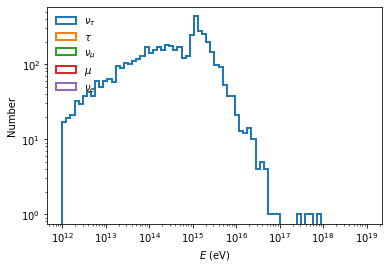

In [9]:
zeros = output['Eout']==0.

for pid in reversed(range(12,17)):
    particle_msk = np.logical_and(np.abs(output['PDG_Encoding'])==pid, ~zeros)
    name = pid_names[pid]
    plt.hist(output['Eout'][particle_msk], bins=bins, label=name,
            lw=2., histtype='step')
    
plt.legend(frameon=False, loc=2)
plt.loglog()
plt.xlabel(r'$E$ (eV)')
plt.ylabel('Number')
plt.show()

Notice how there are only tau neutrinos because we chose to not propagate any secondary particles. 

## Example 3: Propagating through other bodies

In addition to propagating neutrinos through the Earth, you can also propagate neutrinos through the Sun or through any object given a density profile

In [11]:
from taurunner.body import LZ_Sun
from taurunner.body import Body

### First, through a generic `body`

In [12]:
nevents  = 10000                    # number of events to simulate
eini     = 1e15                     # intial energy in eV
theta    = 0.                       # initial incidence angle (nadir) in radians
pid      = 16                       # particle id according to the PDG MC Encoding (nutau)
xs_model = 'dipole'                   # neutrino cross section and tau loss model (CSMS or dipole)
                                   
xs       = CrossSections(xs_model)           # Make cross section object
energies = np.ones(nevents)*eini             # Make array of energies
thetas   = np.ones(nevents)*theta            # Make array of nadir angles in radians

body = Body(1.0, 1e3) # Propagate through a body with a density of 1 and radius of 1e3 km
tracks = make_tracks(thetas)
tau_prop = make_propagator(pid, body)
rand = np.random.RandomState(seed=7)

In [37]:
output = run_MC(energies, thetas, body, xs, tracks, tau_prop, rand)

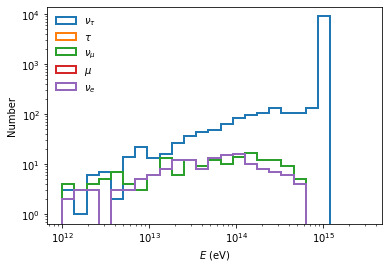

In [39]:
bins  = np.logspace(12, 15.5, 26)
zeros = output['Eout']==0.

for pid in reversed(range(12,17)):
    particle_msk = np.logical_and(np.abs(output['PDG_Encoding'])==pid, ~zeros)
    name = pid_names[pid]
    plt.hist(output['Eout'][particle_msk], bins=bins, label=name,
            lw=2., histtype='step')
    
plt.legend(frameon=False, loc=2)
plt.loglog()
plt.xlabel(r'$E$ (eV)')
plt.ylabel('Number')
plt.show()

### And next, through a model of the Sun

In [45]:
nevents  = 10000                    # number of events to simulate
eini     = 1e15                     # intial energy in eV
theta    = 0.                       # initial incidence angle (nadir) in radians
pid      = 16                       # particle id according to the PDG MC Encoding (nutau)
xs_model = 'dipole'                   # neutrino cross section and tau loss model (CSMS or dipole)
                                   
xs       = CrossSections(xs_model)           # Make cross section object
energies = np.ones(nevents)*eini             # Make array of energies
thetas   = np.ones(nevents)*theta            # Make array of nadir angles in radians

body = HZ_Sun # Propagate through the sun
tracks = make_tracks(thetas)
tau_prop = make_propagator(pid, body)
rand = np.random.RandomState(seed=7)

ValueError: f(a) and f(b) must have different signs

## Example 4: Running from the command line

As is described more thoroughly in the `README`, `taurunner` can also be called from the command line, an example of which is shown inline below

In [25]:
!python ../taurunner/main.py -n 20 -t 0.0 -e 1e9

╒═════════════╤═════════════╤═════════╤═══════╤═══════╤════════════════╕
│        Eini │        Eout │   Theta │   nCC │   nNC │   PDG_Encoding │
╞═════════════╪═════════════╪═════════╪═══════╪═══════╪════════════════╡
│ 1e+18       │ 2.63247e+13 │       0 │     4 │     2 │             16 │
├─────────────┼─────────────┼─────────┼───────┼───────┼────────────────┤
│ 1e+18       │ 2.64058e+13 │       0 │     3 │     1 │             16 │
├─────────────┼─────────────┼─────────┼───────┼───────┼────────────────┤
│ 1e+18       │ 4.0619e+14  │       0 │     5 │     2 │             16 │
├─────────────┼─────────────┼─────────┼───────┼───────┼────────────────┤
│ 1e+18       │ 1.23462e+13 │       0 │     6 │     0 │             16 │
├─────────────┼─────────────┼─────────┼───────┼───────┼────────────────┤
│ 1e+18       │ 1.91583e+14 │       0 │     4 │     3 │             16 │
├─────────────┼─────────────┼─────────┼───────┼───────┼────────────────┤
│ 1e+18       │ 2.13525e+13 │       0 │     5 │    